In [ ]:
from google.colab import drive
drive.mount('/content/drive')

##Dataset and data analysis

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#This notebook is partly adapted from Saravia et al.'s Emotion dataset notebook which is
#available at this link: https://colab.research.google.com/drive/176NSaYjc2eeI-78oLH_F9-YV3po3qQQO?usp=sharing

#In fact, we use the Emotion dataset by Saravia et al. for the first finetuning step. Full citation below.

In [ ]:
_CITATION = """\
@inproceedings{saravia-etal-2018-carer,
    title = "{CARER}: Contextualized Affect Representations for Emotion Recognition",
    author = "Saravia, Elvis  and
      Liu, Hsien-Chi Toby  and
      Huang, Yen-Hao  and
      Wu, Junlin  and
      Chen, Yi-Shin",
    booktitle = "Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing",
    month = oct # "-" # nov,
    year = "2018",
    address = "Brussels, Belgium",
    publisher = "Association for Computational Linguistics",
    url = "https://www.aclweb.org/anthology/D18-1404",
    doi = "10.18653/v1/D18-1404",
    pages = "3687--3697"
}
"""

In [ ]:
#First, we finetune a T5 transformer model on the Emotion dataset (Saravia et al., 2018). This dataset contains
#labelled Twitter posts expressing one of the following emotions: fear, anger, joy, sadness, love, surprise.
#We will only use the emotions that we also have in our own dataset, namely fear, anger, joy, sadness.

import pickle

with open('drive/MyDrive/merged_training.pkl', 'rb') as f:
    data = pickle.load(f)

In [ ]:
#drop rows classified as 'surprise' or 'love' which we don't need, we only want
#sadness, joy, anger and fear

data = data.loc[(data.emotions!='surprise') & (data.emotions!='love')]

label2int = {
  "sadness": 1,
  "joy": 2,
  "anger": 3,
  "fear": 4,
}

In [ ]:
#after the elimination we are left with 367,283 samples
len(data)

367283

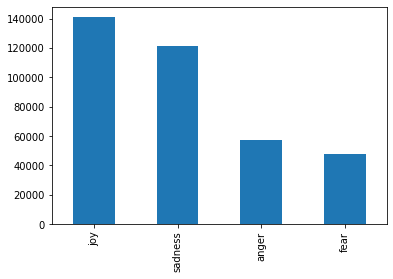

In [ ]:
#checking the label distribution reveals the dataset is unbalanced
data.emotions.value_counts().plot.bar()

In [ ]:
#we downsample the majority classes to match the minority class ('fear') and obtain a more equal split of emotion labels

#separate the majority and minority classes
df_minority  = data[data['emotions']=='fear']
df_majority1 = data[data['emotions']=='joy']
df_majority2 = data[data['emotions']=='sadness']
df_majority3 = data[data['emotions']=='anger']

#downsample majority labels equal to the number of samples in the minority class
df_majority1 = df_majority1.sample(len(df_minority), random_state=0)
df_majority2 = df_majority2.sample(len(df_minority), random_state=0)
df_majority3 = df_majority3.sample(len(df_minority), random_state=0)

#concat the majority and minority dataframes
df_new = pd.concat([df_majority1, df_majority2, df_majority3, df_minority])

#shuffle the dataset
df_new = df_new.sample(frac=1, random_state=0)

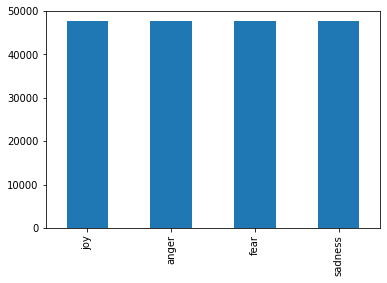

In [ ]:
#check the distribution again, now it's balanced
df_new.emotions.value_counts().plot.bar()

In [ ]:
#get subsample of 20k samples for fine tuning
data = df_new.sample(n=20000);

#reset index
data.reset_index(drop=True, inplace=True)

In [ ]:
#sanity check
len(data)

20000

In [ ]:
#Generate the text files for train, val, and test datasets in proportion 80:10:10

from sklearn.model_selection import train_test_split
import numpy as np

#uncomment the line below to create folder in Drive
#!mkdir 'drive/MyDrive/emotion_data'

train_path = "drive/MyDrive/emotion_data/train.txt"
test_path = "drive/MyDrive/emotion_data/test.txt"
val_path = "drive/MyDrive/emotion_data/val.txt"


#Create training and validation sets using an 80-20 split
input_train, input_val, target_train, target_val = train_test_split(data.text.to_numpy(), 
                                                                    data.emotions.to_numpy(), 
                                                                    test_size=0.2)

# Split the validataion further to obtain a holdout dataset (for testing) -- split 50:50
input_val, input_test, target_val, target_test = train_test_split(input_val, target_val, test_size=0.5)


## create a dataframe for each dataset
train_dataset = pd.DataFrame(data={"text": input_train, "class": target_train})
val_dataset = pd.DataFrame(data={"text": input_val, "class": target_val})
test_dataset = pd.DataFrame(data={"text": input_test, "class": target_test})
final_dataset = {"train": train_dataset, "val": val_dataset , "test": test_dataset }

train_dataset.to_csv(train_path, sep=";",header=False, index=False)
val_dataset.to_csv(val_path, sep=";",header=False, index=False)
test_dataset.to_csv(test_path, sep=";",header=False, index=False)

## T5 fine-tuning on the Emotion dataset


In [ ]:
%%capture
!pip install transformers==2.9.0 
!pip install pytorch_lightning==0.7.5
!pip install sentencepiece

In [ ]:
import argparse
import glob
import os
import json
import time
import logging
import random
import re
from itertools import chain
from string import punctuation

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl


from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5Tokenizer,
    get_linear_schedule_with_warmup
)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


INFO:transformers.file_utils:PyTorch version 1.9.0+cu102 available.
INFO:transformers.file_utils:TensorFlow version 2.6.0 available.


In [ ]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

set_seed(42)

In [ ]:
class T5FineTuner(pl.LightningModule):
  def __init__(self, hparams):
    super(T5FineTuner, self).__init__()
    self.hparams = hparams
    
    self.model = T5ForConditionalGeneration.from_pretrained(hparams.model_name_or_path)
    self.tokenizer = T5Tokenizer.from_pretrained(hparams.tokenizer_name_or_path)
  
  def is_logger(self):
    return self.trainer.proc_rank <= 0
  
  def forward(
      self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None, lm_labels=None
  ):
    return self.model(
        input_ids,
        attention_mask=attention_mask,
        decoder_input_ids=decoder_input_ids,
        decoder_attention_mask=decoder_attention_mask,
        lm_labels=lm_labels,
    )

  def _step(self, batch):
    lm_labels = batch["target_ids"]
    lm_labels[lm_labels[:, :] == self.tokenizer.pad_token_id] = -100

    outputs = self(
        input_ids=batch["source_ids"],
        attention_mask=batch["source_mask"],
        lm_labels=lm_labels,
        decoder_attention_mask=batch['target_mask']
    )

    loss = outputs[0]

    return loss

  def training_step(self, batch, batch_idx):
    loss = self._step(batch)

    tensorboard_logs = {"train_loss": loss}
    return {"loss": loss, "log": tensorboard_logs}
  
  def training_epoch_end(self, outputs):
    avg_train_loss = torch.stack([x["loss"] for x in outputs]).mean()
    tensorboard_logs = {"avg_train_loss": avg_train_loss}
    return {"avg_train_loss": avg_train_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

  def validation_step(self, batch, batch_idx):
    loss = self._step(batch)
    return {"val_loss": loss}
  
  def validation_epoch_end(self, outputs):
    avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
    tensorboard_logs = {"val_loss": avg_loss}
    return {"avg_val_loss": avg_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

  def configure_optimizers(self):
    "Prepare optimizer and schedule (linear warmup and decay)"

    model = self.model
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": self.hparams.weight_decay,
        },
        {
            "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
        },
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)
    self.opt = optimizer
    return [optimizer]
  
  def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_idx, second_order_closure=None):
    if self.trainer.use_tpu:
      xm.optimizer_step(optimizer)
    else:
      optimizer.step()
    optimizer.zero_grad()
    self.lr_scheduler.step()
  
  def get_tqdm_dict(self):
    tqdm_dict = {"loss": "{:.3f}".format(self.trainer.avg_loss), "lr": self.lr_scheduler.get_last_lr()[-1]}

    return tqdm_dict

  def train_dataloader(self):
    train_dataset = get_dataset(tokenizer=self.tokenizer, type_path="train", args=self.hparams)
    dataloader = DataLoader(train_dataset, batch_size=self.hparams.train_batch_size, drop_last=True, shuffle=True, num_workers=4)
    t_total = (
        (len(dataloader.dataset) // (self.hparams.train_batch_size * max(1, self.hparams.n_gpu)))
        // self.hparams.gradient_accumulation_steps
        * float(self.hparams.num_train_epochs)
    )
    scheduler = get_linear_schedule_with_warmup(
        self.opt, num_warmup_steps=self.hparams.warmup_steps, num_training_steps=t_total
    )
    self.lr_scheduler = scheduler
    return dataloader

  def val_dataloader(self):
    val_dataset = get_dataset(tokenizer=self.tokenizer, type_path="val", args=self.hparams)
    return DataLoader(val_dataset, batch_size=self.hparams.eval_batch_size, num_workers=4)

In [ ]:
logger = logging.getLogger(__name__)

class LoggingCallback(pl.Callback):
  def on_validation_end(self, trainer, pl_module):
    logger.info("***** Validation results *****")
    if pl_module.is_logger():
      metrics = trainer.callback_metrics
      #Log results
      for key in sorted(metrics):
        if key not in ["log", "progress_bar"]:
          logger.info("{} = {}\n".format(key, str(metrics[key])))

  def on_test_end(self, trainer, pl_module):
    logger.info("***** Test results *****")

    if pl_module.is_logger():
      metrics = trainer.callback_metrics

      #Log and save results to file
      output_test_results_file = os.path.join(pl_module.hparams.output_dir, "test_results.txt")
      with open(output_test_results_file, "w") as writer:
        for key in sorted(metrics):
          if key not in ["log", "progress_bar"]:
            logger.info("{} = {}\n".format(key, str(metrics[key])))
            writer.write("{} = {}\n".format(key, str(metrics[key])))

In [ ]:
args_dict = dict(
    data_dir="", #path for data files
    output_dir="", #path to save the checkpoints
    model_name_or_path='t5-base',
    tokenizer_name_or_path='t5-base',
    max_seq_length=512,
    learning_rate=1e-4,
    weight_decay=0.0,
    adam_epsilon=1e-8,
    warmup_steps=0,
    train_batch_size=8,
    eval_batch_size=8,
    num_train_epochs=2,
    gradient_accumulation_steps=16,
    n_gpu=1,
    early_stop_callback=False,
    fp_16=False,
    opt_level='O1', 
    max_grad_norm=1.0,
    seed=42,
)

In [ ]:
#Load the tokenizer for the T5-base model
tokenizer = T5Tokenizer.from_pretrained('t5-base')

INFO:filelock:Lock 140108243979664 acquired on /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f.lock
INFO:transformers.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/t5-spiece.model not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmpqeimido6


Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

INFO:transformers.file_utils:storing https://s3.amazonaws.com/models.huggingface.co/bert/t5-spiece.model in cache at /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f
INFO:filelock:Lock 140108243979664 released on /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f.lock
INFO:transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/t5-spiece.model from cache at /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f

In [ ]:
#try out the tokenizer
text = "I am sad and feel like I have no energy today."
enc = tokenizer.encode_plus(text)
print(enc)

{'input_ids': [27, 183, 6819, 11, 473, 114, 27, 43, 150, 827, 469, 5], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [ ]:
#check how it encodes the labels (they're all single ids)
emotions = [ "sadness", "joy", "anger", "fear"]
for em in emotions:
  print(tokenizer.encode(em))

[24784]
[3922]
[11213]
[2971]


In [ ]:
class EmotionDataset(Dataset):
  def __init__(self, tokenizer, data_dir, type_path,  max_len=512):
    self.path = os.path.join(data_dir, type_path + '.txt')

    self.data_column = "text"
    self.class_column = "emotion"
    self.data = pd.read_csv(self.path, sep=";", header=None, names=[self.data_column, self.class_column],
                            engine="python")
    
    self.max_len = max_len
    self.tokenizer = tokenizer
    self.inputs = []
    self.targets = []

    self._build()
  
  def __len__(self):
    return len(self.inputs)
  
  def __getitem__(self, index):
    source_ids = self.inputs[index]["input_ids"].squeeze()
    target_ids = self.targets[index]["input_ids"].squeeze()

    src_mask    = self.inputs[index]["attention_mask"].squeeze()  #might need to squeeze
    target_mask = self.targets[index]["attention_mask"].squeeze()  #might need to squeeze

    return {"source_ids": source_ids, "source_mask": src_mask, "target_ids": target_ids, "target_mask": target_mask}
  
  def _build(self):
    for idx in range(len(self.data)):
      input_, target = self.data.loc[idx, self.data_column], self.data.loc[idx, self.class_column]      
      
      input_ = input_ + ' </s>'
      target = target + " </s>"

       #tokenize inputs
      tokenized_inputs = self.tokenizer.batch_encode_plus(
          [input_], max_length=self.max_len, pad_to_max_length=True, return_tensors="pt"
      )
       #tokenize targets
      tokenized_targets = self.tokenizer.batch_encode_plus(
          [target], max_length=2, pad_to_max_length=True, return_tensors="pt"
      )

      self.inputs.append(tokenized_inputs)
      self.targets.append(tokenized_targets)

In [ ]:
#sanity check, val length should be 2000
dataset = EmotionDataset(tokenizer, 'drive/MyDrive/emotion_data/', 'val', 512)
len(dataset)

2000

In [ ]:
#view one sample
data = dataset[77]
print(tokenizer.decode(data['source_ids']))
print(tokenizer.decode(data['target_ids']))

i feel triumphant and defeated all at once may nd by jules leave a reply so the lovely a href http philosophywithfries
joy


### Train

As I said above there's no need to change the model or add task specific head or any other hyperparameters, we'll just change the dataset and that's it!

In [ ]:
#uncomment the line below to create folder in Drive
#!mkdir -p 'drive/MyDrive/t5_emotion'

In [ ]:
args_dict.update({'data_dir': 'drive/MyDrive/emotion_data/', 'output_dir': 'drive/MyDrive/t5_emotion', 'num_train_epochs':2})
args = argparse.Namespace(**args_dict)
print(args_dict)

{'data_dir': 'drive/MyDrive/emotion_data/', 'output_dir': 'drive/MyDrive/t5_emotion', 'model_name_or_path': 't5-base', 'tokenizer_name_or_path': 't5-base', 'max_seq_length': 512, 'learning_rate': 0.0001, 'weight_decay': 0.0, 'adam_epsilon': 1e-08, 'warmup_steps': 0, 'train_batch_size': 8, 'eval_batch_size': 8, 'num_train_epochs': 2, 'gradient_accumulation_steps': 16, 'n_gpu': 1, 'early_stop_callback': False, 'fp_16': False, 'opt_level': 'O1', 'max_grad_norm': 1.0, 'seed': 42}


In [ ]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filepath=args.output_dir, prefix="checkpoint", monitor="val_loss", mode="min", save_top_k=5
)

train_params = dict(
    accumulate_grad_batches=args.gradient_accumulation_steps,
    gpus=args.n_gpu,
    max_epochs=args.num_train_epochs,
    early_stop_callback=False,
    precision= 16 if args.fp_16 else 32,
    amp_level=args.opt_level,
    gradient_clip_val=args.max_grad_norm,
    checkpoint_callback=checkpoint_callback,
    callbacks=[LoggingCallback()],
)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: Checkpoint directory drive/MyDrive/t5_emotion exists and is not empty with save_top_k != 0.All files in this directory will be deleted when a checkpoint is saved!
  warnings.warn(*args, **kwargs)


In [ ]:
def get_dataset(tokenizer, type_path, args):
  return EmotionDataset(tokenizer=tokenizer, data_dir=args.data_dir, type_path=type_path,  max_len=args.max_seq_length)

In [ ]:
model = T5FineTuner(args)

In [ ]:
trainer = pl.Trainer(**train_params)

INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


In [ ]:
trainer.fit(model)

In [ ]:
#save model (uncomment to save)
'''
torch.save(model.state_dict(), 'drive/MyDrive/t5_emotion/T5emotion_finetuned.pt')
'''

In [ ]:
device = torch.device('cuda:0')

In [ ]:
#load model (uncomment to load)
'''
model = T5FineTuner(args)
model.load_state_dict(torch.load('drive/MyDrive/t5_emotion/T5emotion_finetuned.pt'))
model.to(device)
'''

## Evaluate on the test set

In [ ]:
import textwrap
from tqdm.auto import tqdm
from sklearn import metrics

In [ ]:
dataset = EmotionDataset(tokenizer, 'drive/MyDrive/emotion_data', 'test', 512)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
it = iter(loader)

In [ ]:
batch = next(it)
batch["source_ids"].shape

torch.Size([32, 512])

In [ ]:
outs = model.model.generate(input_ids=batch['source_ids'].cuda(), 
                              attention_mask=batch['source_mask'].cuda(), 
                              max_length=2)

dec = [tokenizer.decode(ids) for ids in outs]

texts = [tokenizer.decode(ids) for ids in batch['source_ids']]
targets = [tokenizer.decode(ids) for ids in batch['target_ids']]

In [ ]:
#print out some predictions
for i in range(32):
    c = texts[i]
    lines = textwrap.wrap("text:\n%s\n" % c, width=100)
    print("\n".join(lines))
    print("\nActual sentiment: %s" % targets[i])
    print("predicted sentiment: %s" % dec[i])
    print("=====================================================================\n")

text: i heard they were robbed i feel very agitated for the robbers but i pray that you are fine

Actual sentiment: fear
predicted sentiment: fear

text: i am trying to redirect myself in the fact i feel miserable and i am crabby with myself right
now

Actual sentiment: sadness
predicted sentiment: sadness

text: im really feeling a lot more resolved on life

Actual sentiment: joy
predicted sentiment: joy

text: i feel very angry typing this down now haha

Actual sentiment: anger
predicted sentiment: anger

text: i feel less distressed by present woes four more years of boris

Actual sentiment: fear
predicted sentiment: fear

text: i was super tired but i found myself getting annoyed really easily as the night went on and it
was over nothing too i hate feeling irritable like that

Actual sentiment: anger
predicted sentiment: anger

text: i am looking for alternatives that feel to me to be safer options to meet people however
through all of this time jacen and jaina have been my faithfu

#### Test Metrics

In [ ]:
dataset = EmotionDataset(tokenizer, 'drive/MyDrive/emotion_data', 'test', 512)
loader = DataLoader(dataset, batch_size=32, num_workers=4)
model.model.eval()
outputs = []
targets = []
for batch in tqdm(loader):
  outs = model.model.generate(input_ids=batch['source_ids'].cuda(), 
                              attention_mask=batch['source_mask'].cuda(), 
                              max_length=2)

  dec = [tokenizer.decode(ids) for ids in outs]
  target = [tokenizer.decode(ids) for ids in batch["target_ids"]]
  
  outputs.extend(dec)
  targets.extend(target)

  0%|          | 0/63 [00:00<?, ?it/s]

In [ ]:
for i, out in enumerate(outputs):
  if out not in emotions:
    print(i, 'detected invalid prediction')
    #deal with invalid predictions if any:
    del outputs[i]
    del targets[i]

1140 detected invalid prediction


In [ ]:
print(metrics.classification_report(targets, outputs, digits=4))

              precision    recall  f1-score   support

       anger     0.9553    0.9315    0.9433       482
        fear     0.9501    0.9753    0.9625       527
         joy     0.9721    0.9644    0.9683       506
     sadness     0.9342    0.9380    0.9361       484

    accuracy                         0.9530      1999
   macro avg     0.9529    0.9523    0.9525      1999
weighted avg     0.9531    0.9530    0.9529      1999



Now lets plot  the confusion matrix and see for which classes our model is getting confused

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
cm = metrics.confusion_matrix(targets, outputs)

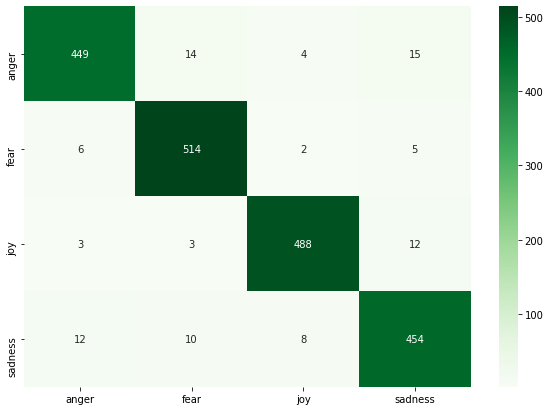

In [ ]:
df_cm = pd.DataFrame(cm, index = ["anger", "fear", "joy", "sadness"], columns = ["anger", "fear", "joy", "sadness"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap='Greens', fmt='g')

#Further finetune T5 model on our 'patient response' data

In [ ]:
#define paths for train, val, test
train_path = "drive/MyDrive/emotion_data/my_train.txt"
test_path = "drive/MyDrive/emotion_data/my_test.txt"
val_path = "drive/MyDrive/emotion_data/my_val.txt"

####Redefine class with new paths

In [ ]:
class T5FineTuner(pl.LightningModule):
  def __init__(self, hparams):
    super(T5FineTuner, self).__init__()
    self.hparams = hparams
    
    self.model = T5ForConditionalGeneration.from_pretrained(hparams.model_name_or_path)
    self.tokenizer = T5Tokenizer.from_pretrained(hparams.tokenizer_name_or_path)
  
  def is_logger(self):
    return self.trainer.proc_rank <= 0
  
  def forward(
      self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None, lm_labels=None
  ):
    return self.model(
        input_ids,
        attention_mask=attention_mask,
        decoder_input_ids=decoder_input_ids,
        decoder_attention_mask=decoder_attention_mask,
        lm_labels=lm_labels,
    )

  def _step(self, batch):
    lm_labels = batch["target_ids"]
    lm_labels[lm_labels[:, :] == self.tokenizer.pad_token_id] = -100

    outputs = self(
        input_ids=batch["source_ids"],
        attention_mask=batch["source_mask"],
        lm_labels=lm_labels,
        decoder_attention_mask=batch['target_mask']
    )

    loss = outputs[0]

    return loss

  def training_step(self, batch, batch_idx):
    loss = self._step(batch)

    tensorboard_logs = {"train_loss": loss}
    return {"loss": loss, "log": tensorboard_logs}
  
  def training_epoch_end(self, outputs):
    avg_train_loss = torch.stack([x["loss"] for x in outputs]).mean()
    tensorboard_logs = {"avg_train_loss": avg_train_loss}
    return {"avg_train_loss": avg_train_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

  def validation_step(self, batch, batch_idx):
    loss = self._step(batch)
    return {"val_loss": loss}
  
  def validation_epoch_end(self, outputs):
    avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
    tensorboard_logs = {"val_loss": avg_loss}
    return {"avg_val_loss": avg_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

  def configure_optimizers(self):
    "Prepare optimizer and schedule (linear warmup and decay)"

    model = self.model
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": self.hparams.weight_decay,
        },
        {
            "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
        },
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)
    self.opt = optimizer
    return [optimizer]
  
  def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_idx, second_order_closure=None):
    if self.trainer.use_tpu:
      xm.optimizer_step(optimizer)
    else:
      optimizer.step()
    optimizer.zero_grad()
    self.lr_scheduler.step()
  
  def get_tqdm_dict(self):
    tqdm_dict = {"loss": "{:.3f}".format(self.trainer.avg_loss), "lr": self.lr_scheduler.get_last_lr()[-1]}

    return tqdm_dict

  def train_dataloader(self):
    train_dataset = get_dataset(tokenizer=self.tokenizer, type_path="my_train", args=self.hparams)
    dataloader = DataLoader(train_dataset, batch_size=self.hparams.train_batch_size, drop_last=True, shuffle=True, num_workers=4)
    t_total = (
        (len(dataloader.dataset) // (self.hparams.train_batch_size * max(1, self.hparams.n_gpu)))
        // self.hparams.gradient_accumulation_steps
        * float(self.hparams.num_train_epochs)
    )
    scheduler = get_linear_schedule_with_warmup(
        self.opt, num_warmup_steps=self.hparams.warmup_steps, num_training_steps=t_total
    )
    self.lr_scheduler = scheduler
    return dataloader

  def val_dataloader(self):
    val_dataset = get_dataset(tokenizer=self.tokenizer, type_path="my_val", args=self.hparams)
    return DataLoader(val_dataset, batch_size=self.hparams.eval_batch_size, num_workers=4)

#Train model on our dataset

In [ ]:
#load tokenizer for our model
tokenizer = T5Tokenizer.from_pretrained('t5-base')

INFO:transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/t5-spiece.model from cache at /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f


In [ ]:
dataset = EmotionDataset(tokenizer, 'drive/MyDrive/emotion_data/', 'my_val', 512)

In [ ]:
#show one sample
data = dataset[57]
print(tokenizer.decode(data['source_ids']))
print(tokenizer.decode(data['target_ids']))

i am feeling alive and blessed
joy


In [ ]:
#clear cache before training
torch.cuda.empty_cache()

In [ ]:
args_dict = dict(
    data_dir="", # path for data files
    output_dir="", # path to save the checkpoints
    model_name_or_path='t5-base',
    tokenizer_name_or_path='t5-base',
    max_seq_length=512,
    learning_rate=1e-3,
    weight_decay=0.0,
    adam_epsilon=1e-3,
    warmup_steps=0,
    train_batch_size=1,
    eval_batch_size=1,
    num_train_epochs=6,
    gradient_accumulation_steps=16, 
    n_gpu=1,
    early_stop_callback=False,
    fp_16=False, 
    opt_level='O1', 
    max_grad_norm=1.0,
    seed=42,
)

In [ ]:
args_dict.update({'data_dir': 'drive/MyDrive/emotion_data/', 'output_dir': 'drive/MyDrive/t5_emotion', 'num_train_epochs':6})
args = argparse.Namespace(**args_dict)
print(args_dict)

{'data_dir': 'drive/MyDrive/emotion_data/', 'output_dir': 'drive/MyDrive/t5_emotion', 'model_name_or_path': 't5-base', 'tokenizer_name_or_path': 't5-base', 'max_seq_length': 512, 'learning_rate': 0.001, 'weight_decay': 0.0, 'adam_epsilon': 0.001, 'warmup_steps': 0, 'train_batch_size': 1, 'eval_batch_size': 1, 'num_train_epochs': 6, 'gradient_accumulation_steps': 16, 'n_gpu': 1, 'early_stop_callback': False, 'fp_16': False, 'opt_level': 'O1', 'max_grad_norm': 1.0, 'seed': 42}


In [ ]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filepath=args.output_dir, prefix="checkpoint", monitor="val_loss", mode="min", save_top_k=5
)

train_params = dict(
    accumulate_grad_batches=args.gradient_accumulation_steps,
    gpus=args.n_gpu,
    max_epochs=args.num_train_epochs,
    early_stop_callback=False,
    precision= 16 if args.fp_16 else 32,
    amp_level=args.opt_level,
    gradient_clip_val=args.max_grad_norm,
    checkpoint_callback=checkpoint_callback,
    callbacks=[LoggingCallback()],
)

In [ ]:
def get_dataset(tokenizer, type_path, args):
  return EmotionDataset(tokenizer=tokenizer, data_dir=args.data_dir, type_path=type_path,  max_len=args.max_seq_length)

In [ ]:
#create instance of model and load previously finetuned weights
model = T5FineTuner(args)
model.load_state_dict(torch.load('drive/MyDrive/t5_emotion/T5emotion_finetuned.pt'))

In [ ]:
trainer = pl.Trainer(**train_params)

INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


In [ ]:
#training loop
trainer.fit(model)

In [ ]:
#save model (uncomment to save)
'''
torch.save(model.state_dict(), 'drive/MyDrive/t5_emotion/T5emotion_twicefinetuned.pt')
'''

In [ ]:
device = torch.device('cuda:0')

In [ ]:
#load model (uncomment to load)
'''
model = T5FineTuner(args)
model.load_state_dict(torch.load('drive/MyDrive/t5_emotion/T5emotion_twicefinetuned.pt'))
model.to(device)
'''

##Test set eval

In [ ]:
import textwrap
from tqdm.auto import tqdm
from sklearn import metrics

In [ ]:
dataset = EmotionDataset(tokenizer, 'drive/MyDrive/emotion_data', 'my_test', 512)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
it = iter(loader)

In [ ]:
batch = next(it)
batch["source_ids"].shape

torch.Size([32, 512])

In [ ]:
outs = model.model.generate(input_ids=batch['source_ids'].cuda(), 
                              attention_mask=batch['source_mask'].cuda(), 
                              max_length=2)

dec = [tokenizer.decode(ids) for ids in outs]

texts = [tokenizer.decode(ids) for ids in batch['source_ids']]
targets = [tokenizer.decode(ids) for ids in batch['target_ids']]

In [ ]:
#print some predictions to view
for i in range(32):
    c = texts[i]
    lines = textwrap.wrap("text:\n%s\n" % c, width=100)
    print("\n".join(lines))
    print("\nActual sentiment: %s" % targets[i])
    print("predicted sentiment: %s" % dec[i])
    print("=====================================================================\n")

text: i am so angry for something that happened today

Actual sentiment: anger
predicted sentiment: anger

text: i feel very angry because my sister hurt me a lot

Actual sentiment: anger
predicted sentiment: anger

text: todays not a good day

Actual sentiment: sadness
predicted sentiment: sadness

text: i cried before

Actual sentiment: sadness
predicted sentiment: sadness

text: i am angry with my friend because he disobeyed me

Actual sentiment: anger
predicted sentiment: anger

text: excellent its my birthday

Actual sentiment: joy
predicted sentiment: joy

text: my heart feels like it is pounding out of my chest i feel so anxious today

Actual sentiment: fear
predicted sentiment: fear

text: i am so sad today

Actual sentiment: sadness
predicted sentiment: sadness

text: i want to cry

Actual sentiment: sadness
predicted sentiment: sadness

text: i am feeling blue today as i have had an unpleasant review from one of my customers today

Actual sentiment: sadness
predicted sentimen

In [ ]:
#predict whole test set
dataset = EmotionDataset(tokenizer, 'drive/MyDrive/emotion_data', 'my_test', 512)
loader = DataLoader(dataset, batch_size=32, num_workers=4)
model.model.eval()
outputs = []
targets = []
for batch in tqdm(loader):
  outs = model.model.generate(input_ids=batch['source_ids'].cuda(), 
                              attention_mask=batch['source_mask'].cuda(), 
                              max_length=2)

  dec = [tokenizer.decode(ids) for ids in outs]
  target = [tokenizer.decode(ids) for ids in batch["target_ids"]]
  
  outputs.extend(dec)
  targets.extend(target)

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
for i, out in enumerate(outputs):
  if out not in emotions:
    print(i, 'detected invalid prediction')
    #deal with invalid predictions if any:
    del outputs[i]
    del targets[i]

In [ ]:
#other metrics
print(metrics.classification_report(targets, outputs, digits=4))

              precision    recall  f1-score   support

       anger     0.8929    0.9259    0.9091        27
        fear     0.9677    0.9375    0.9524        32
         joy     1.0000    0.9200    0.9583        25
     sadness     0.8919    0.9429    0.9167        35

    accuracy                         0.9328       119
   macro avg     0.9381    0.9316    0.9341       119
weighted avg     0.9352    0.9328    0.9333       119



####Confusion matrix

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
cm = metrics.confusion_matrix(targets, outputs)

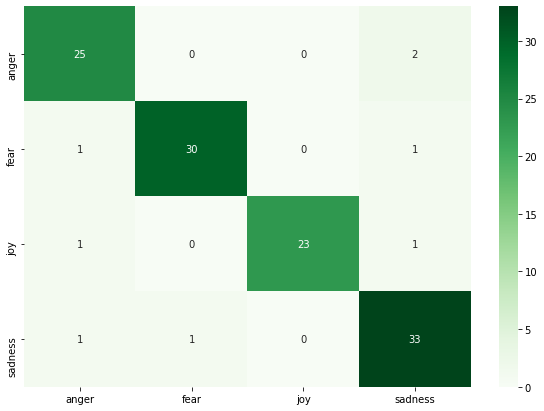

In [ ]:
df_cm = pd.DataFrame(cm, index = ["anger", "fear", "joy", "sadness"], columns = ["anger", "fear", "joy", "sadness"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap='Greens', fmt='g')

##Generate emotion prediction for an individual sentence:

In [ ]:
#define get_emotion function to generate individual prediction

import re

def get_emotion(text):
  text = re.sub(r'[^\w\s]', '', text)
  text = text.lower()
  input_ids = tokenizer.encode(text + '</s>', return_tensors='pt').cuda()

  output = model.model.generate(input_ids=input_ids,
               max_length=2).cuda()

  dec = [tokenizer.decode(ids) for ids in output]
  label = dec[0]
  return label

In [ ]:
text="I feel as if nothing matters anymore" #change as necessary
get_emotion(text)

'sadness'